In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [132]:
dailyData = pd.read_csv("train.csv")
dailyData = dailyData.rename(columns={'pickup_datetime':'datetime'})
dailyData[["datetime"]] = dailyData[["datetime"]].astype(str)

# Remove the nan from datetime
dailyData = dailyData[dailyData['datetime']!='nan']
dailyData = dailyData[pd.notnull(dailyData['dropoff_zone'])]
dailyData = dailyData[pd.notnull(dailyData['pickup_zone'])]
dailyData = dailyData[pd.notnull(dailyData['dropoff_borough'])]
dailyData = dailyData[pd.notnull(dailyData['pickup_borough'])]

# Remove the Unknown from borough
dailyData = dailyData[dailyData['dropoff_borough']!='Unknown']
dailyData = dailyData[dailyData['pickup_borough']!='Unknown']

# Fill nan with specific number
dailyData['passenger_count'].fillna(1,inplace=True)
dailyData['VendorID'].fillna(2,inplace=True)

# convert negative trip_distance to positive values
for index in dailyData.index:
    if dailyData['trip_distance'][index]<0:
        dailyData['trip_distance'][index] = -dailyData['trip_distance'][index]

# get weekday
dailyData['year'] = dailyData.datetime.apply(lambda x : x.split()[0].split("-")[0])
dailyData['month'] = dailyData.datetime.apply(lambda x : x.split()[0].split("-")[1])
dailyData['day'] = dailyData.datetime.apply(lambda x : x.split()[0].split("-")[2])
dailyData['hour'] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.datetime.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString.split()[0],"%Y-%m-%d").weekday()])

# remove all data with trip_distance=0
dailyData = dailyData.query('trip_distance > 0.1')

# combine pickup_zone & dropoff_zone, hour & weekkday
dailyData['zone'] = dailyData.apply(lambda x: str(x['pickup_zone'])+"-"+str(x['dropoff_zone']),axis=1)
dailyData['hour_weekday'] = dailyData.apply(lambda x: str(x['hour'])+"-"+str(x['weekday']),axis=1)

# top speed for taxi 36s/mile
dailyData = dailyData.query('duration >= trip_distance*36')

# speed on foot 1200s/mile
dailyData1 = dailyData.query('duration <= trip_distance*1200')

# include some severe traffic jam and short trip distance
dailyData2 = dailyData.query('duration > trip_distance*1200 and trip_distance < 10 and duration < 7200')
dailyData = dailyData1.append(dailyData2)
dailyData.reset_index(inplace=True)
dailyData.drop('index',inplace=True,axis=1)

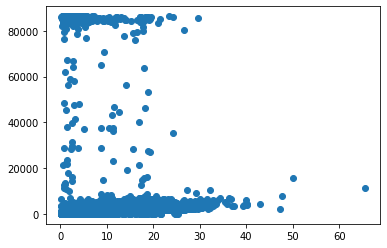

In [16]:
plt.scatter(dailyData['trip_distance'],dailyData['duration'])
# sn.distplot(dailyData["trip_distance"])

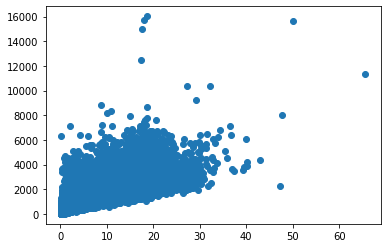

In [94]:
plt.scatter(dailyData['trip_distance'],dailyData['duration'])
# sn.distplot(dailyData["trip_distance"])

In [83]:
dailyData.dtypes

row_id               int64
VendorID           float64
datetime            object
passenger_count    float64
trip_distance      float64
pickup_borough      object
pickup_zone         object
dropoff_borough     object
dropoff_zone        object
duration             int64
year                object
month               object
day                 object
hour                object
weekday             object
dtype: object

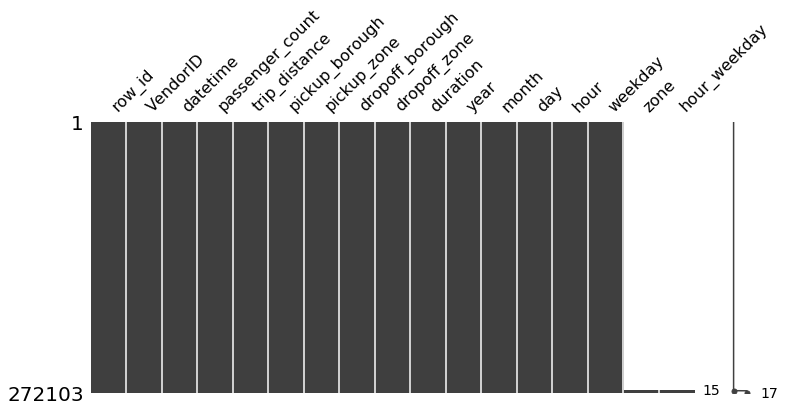

In [95]:
msno.matrix(dailyData,figsize=(12,5))

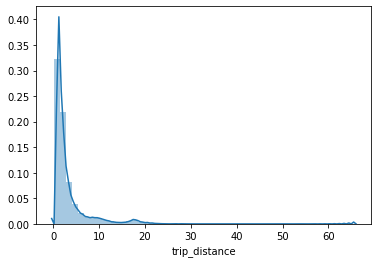

In [116]:
sn.distplot(dailyData["trip_distance"])

[Text(0, 0.5, 'Duration'),
 Text(0.5, 0, 'pickup_borough'),
 Text(0.5, 1.0, 'Box Plot On Count Across Pickup Borough')]

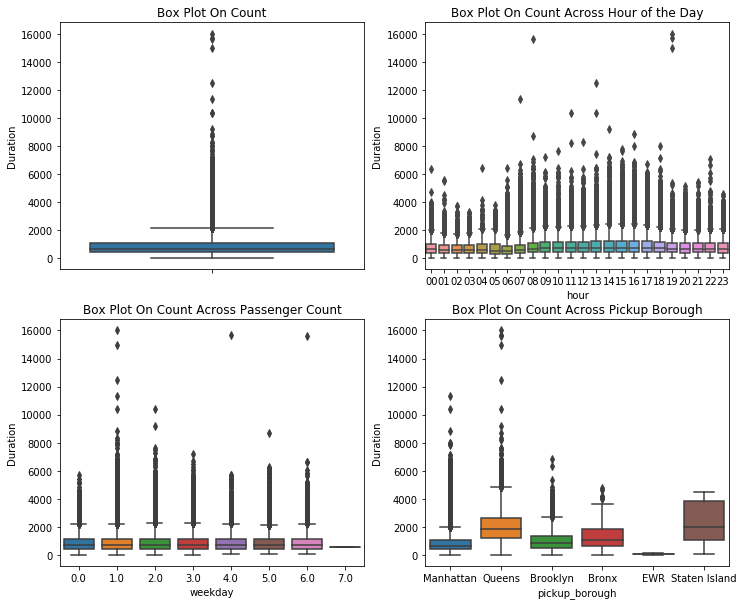

In [133]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=dailyData,y="duration",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="duration",x="hour",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="duration",x="passenger_count",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="duration",x="pickup_borough",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Duration',title="Box Plot On Count")
axes[0][1].set(xlabel='hour', ylabel='Duration',title="Box Plot On Count Across Hour of the Day")
axes[1][0].set(xlabel='weekday', ylabel='Duration',title="Box Plot On Count Across Passenger Count")
axes[1][1].set(xlabel='pickup_borough', ylabel='Duration',title="Box Plot On Count Across Pickup Borough")

In [120]:
dailyData = dailyData.query('duration < 10000')

[Text(0, 0.5, 'Duration'),
 Text(0.5, 0, 'pickup_borough'),
 Text(0.5, 1.0, 'Box Plot On Count Across Pickup Borough')]

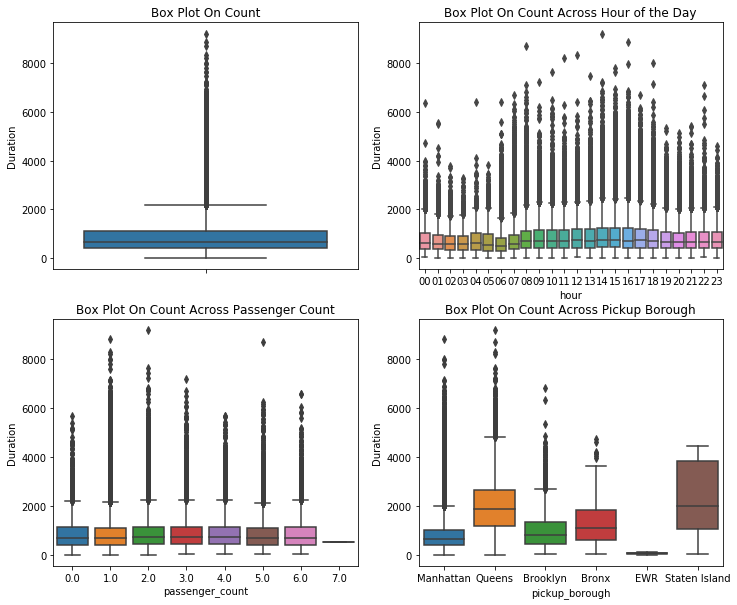

In [121]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=dailyData,y="duration",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="duration",x="hour",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="duration",x="passenger_count",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="duration",x="pickup_borough",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Duration',title="Box Plot On Count")
axes[0][1].set(xlabel='hour', ylabel='Duration',title="Box Plot On Count Across Hour of the Day")
axes[1][0].set(xlabel='passenger_count', ylabel='Duration',title="Box Plot On Count Across Passenger Count")
axes[1][1].set(xlabel='pickup_borough', ylabel='Duration',title="Box Plot On Count Across Pickup Borough")

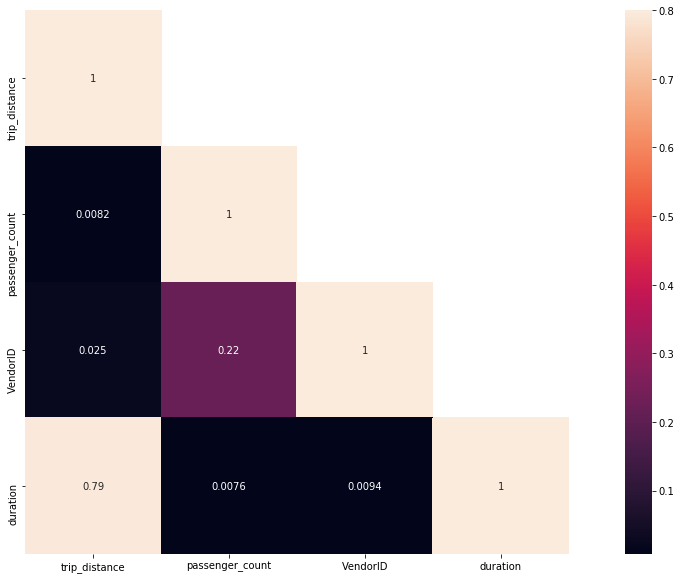

In [122]:
corrMatt = dailyData[["trip_distance","passenger_count","VendorID","hour","duration"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

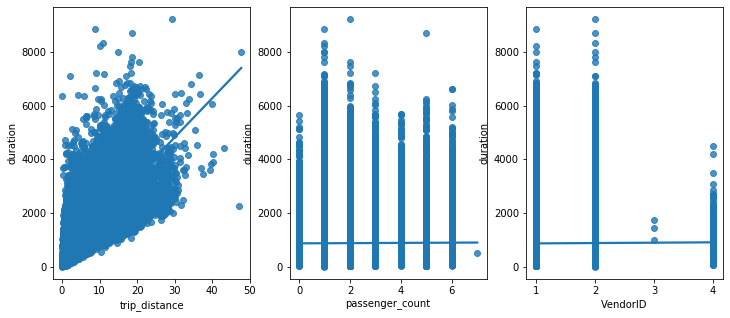

In [123]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="trip_distance", y="duration", data=dailyData,ax=ax1)
sn.regplot(x="passenger_count", y="duration", data=dailyData,ax=ax2)
sn.regplot(x="VendorID", y="duration", data=dailyData,ax=ax3)

((array([-4.56084226, -4.37101574, -4.26806767, ...,  4.26806767,
          4.37101574,  4.56084226]),
  array([1.94591015, 2.30258509, 2.39789527, ..., 9.07119324, 9.08692903,
         9.12750209])),
 (0.7400632325286888, 6.512169455451165, 0.9992829561806572))

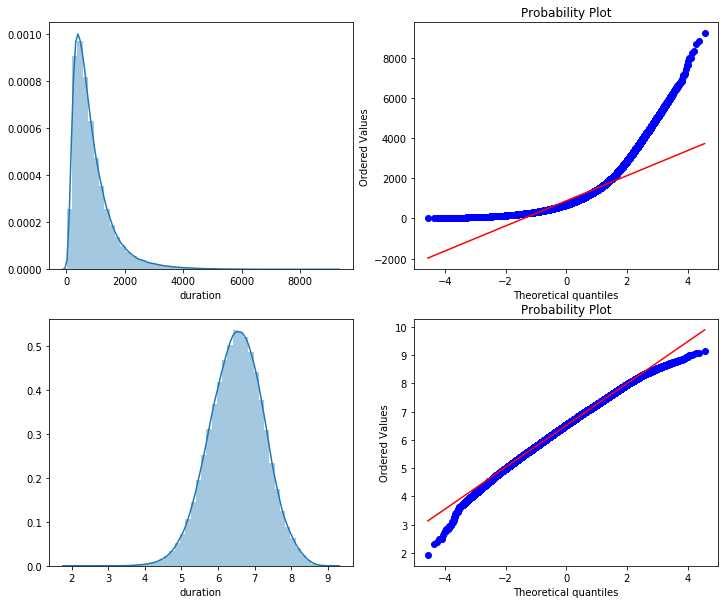

In [129]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(dailyData["duration"],ax=axes[0][0])
stats.probplot(dailyData["duration"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log1p(dailyData["duration"]),ax=axes[1][0])
stats.probplot(np.log1p(dailyData["duration"]), dist='norm', fit=True, plot=axes[1][1])

[Text(0, 0.5, 'Duration'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Duration By Hour Of The Day Across year'),
 None]

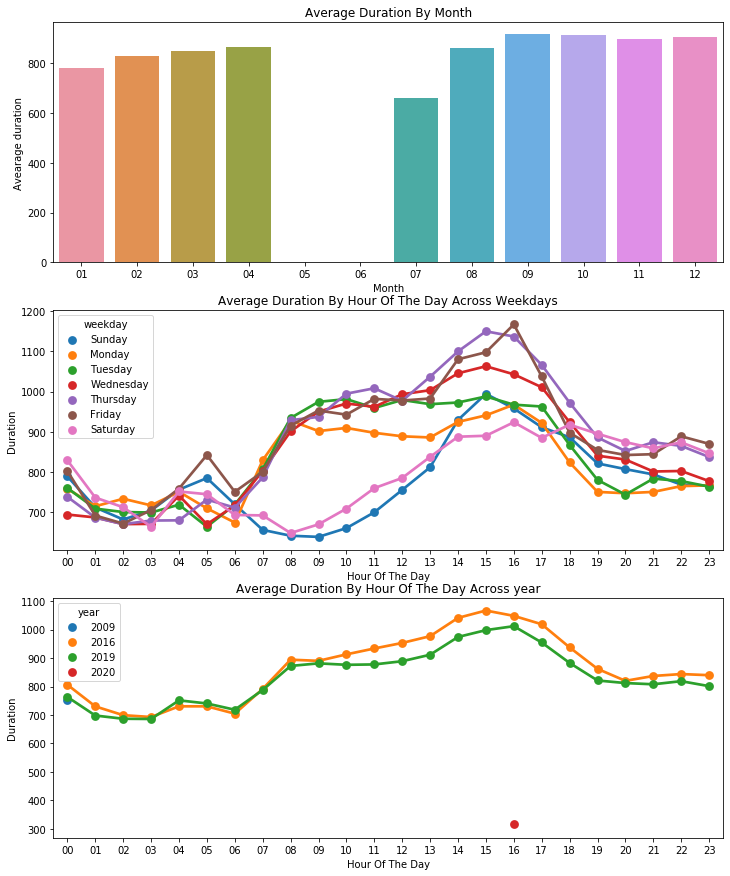

In [131]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(12,15)
sortOrder = ["01","02","03","04","05","06","07","08","09","10","11","12"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby("month")["duration"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="duration",ascending=False)
sn.barplot(data=monthSorted,x="month",y="duration",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage duration',title="Average Duration By Month")

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","weekday"],sort=True)["duration"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["duration"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Duration',title="Average Duration By Hour Of The Day Across Weekdays",label='big')

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","year"],sort=True)["duration"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["duration"],hue=hourAggregated["year"], data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Duration',title="Average Duration By Hour Of The Day Across year",label='big')


In [134]:
def graph_insight(data):
    print(set(data.dtypes.tolist()))
    df_num = data.select_dtypes(include = ['float64', 'int64'])
    df_num.hist(figsize=(16, 16), bins=50, xlabelsize=8, ylabelsize=8);

{dtype('O'), dtype('int64'), dtype('float64')}


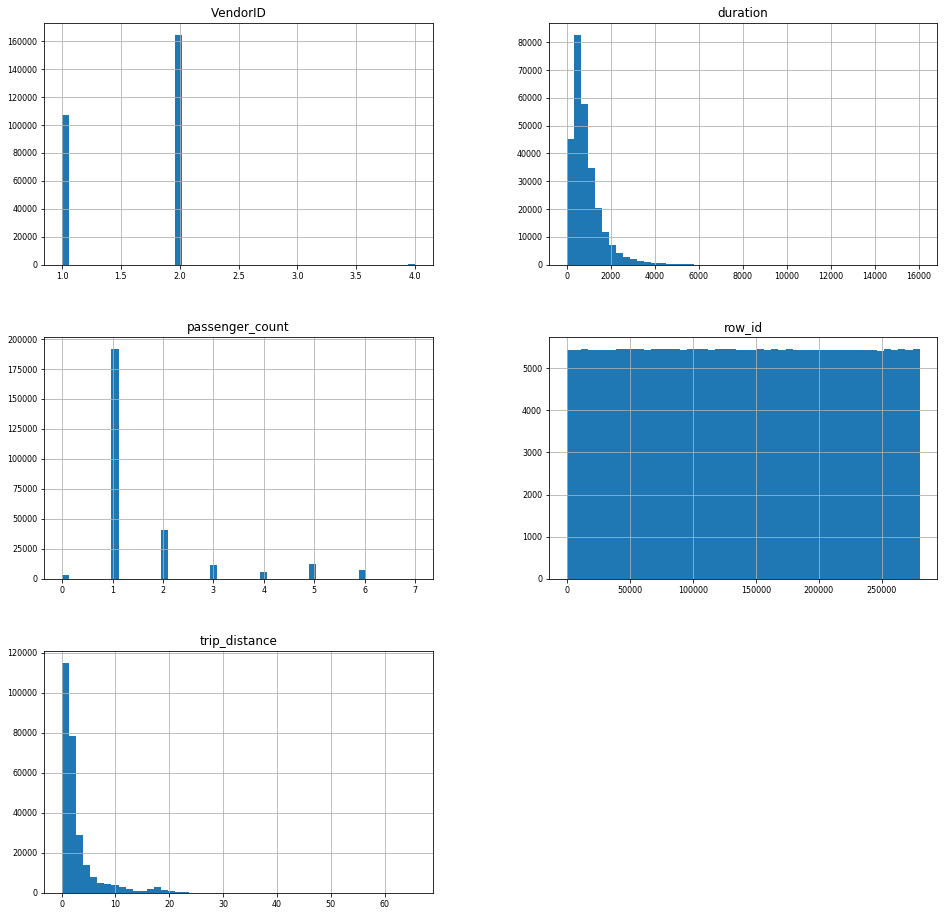

In [135]:
graph_insight(dailyData)